<a href="https://colab.research.google.com/github/zdwhite/Thinkful-Unit-3/blob/master/Challenge_Model_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement





Find a data set and build a KNN Regression and an OLS regression

How similar are they? 

Do they miss in different ways?

Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. 

Lastly, try to note what it is about the data that causes the better model to outperform the weaker model

# Predicting flight cancelations

## The Data

The data used for this challenge was obtained from the [Bureau of Transportation Statistic](https://www.transtats.bts.gov/DL_SelectFields.asp)

For this challenge we'll be using 1 month of data as they are quite large.

A flight is considered delayed when it arrives 15 or more minutes than the schedule.

Delayed minutes are calculated only for flights that meet this criterium.

In [0]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
%matplotlib inline


In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/zdwhite/Thinkful-Unit-3/master/442827422_T_ONTIME_REPORTING.csv', delimiter= ',')

In [3]:
#Drop unnamed column this always happens when opening excel CSVs
df.drop('Unnamed: 9',axis=1,inplace=True)

df.head()

,YEAR,MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CANCELLED,CRS_ELAPSED_TIME,DISTANCE
0,2018,2,4,F9,LAS,MIA,0.0,273.0,2174.0
1,2018,2,4,F9,LAX,DEN,0.0,140.0,862.0
2,2018,2,4,F9,LAS,ATL,0.0,225.0,1747.0
3,2018,2,4,F9,LAS,MCO,0.0,261.0,2039.0
4,2018,2,4,F9,DEN,MCO,0.0,215.0,1546.0


In [101]:
##### Dealing with Null / NaN values
print(df[df['CRS_ELAPSED_TIME'].isnull()])

# There are so few NaN values lets  just take them out and not worry about it.

df=df[df['CRS_ELAPSED_TIME'].notnull()]

        YEAR  MONTH  DAY_OF_WEEK OP_UNIQUE_CARRIER ORIGIN DEST  CANCELLED  \
102654  2018      2            1                YX    PHL  SAV        0.0   
102656  2018      2            2                YX    SDF  DCA        0.0   
102659  2018      2            1                YX    CMH  CLT        0.0   
102660  2018      2            1                YX    EYW  CLT        0.0   
114979  2018      2            4                YX    EWR  DTW        0.0   
114982  2018      2            2                YX    EWR  RDU        0.0   
114983  2018      2            3                YX    EYW  EWR        0.0   

        CRS_ELAPSED_TIME  DISTANCE  Airline_Carrier_Code  Origin_Code  \
102654               NaN     629.0                    17          245   
102656               NaN     474.0                    17          288   
102659               NaN     347.0                    17           68   
102660               NaN     736.0                    17          105   
114979            

### Data Types



In [4]:
df.columns

Index(['YEAR', 'MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST',
       'CANCELLED', 'CRS_ELAPSED_TIME', 'DISTANCE'],
      dtype='object')

A complete description of each column header can be found [here](https://www.transtats.bts.gov/DL_SelectFields.asp)

Looking at the columns above let's categorize them and lay out a work flow

1.   Year - Integer, categorical and static
   * Drop this column
2. Month - Integer, categorical and static
   * Drop this column
3. Day of the Week, integer categorical
   * Do Nothing
4.  Carrier, String, Categorical
   * This column needs to be coded to integer values
5.   Origin - String, categorical
   * Coded to integer values
6.   Dest - String, categorical
   *  Code to integer values
7.   Cancelled - Binary (**dependant variable**)
   *  do nothing
8.   CRS_ELAPSED_TIME - Float - Continuous
   * do nothing

### Encode the categorical variables

In [6]:
df['OP_UNIQUE_CARRIER'].unique()

array(['F9', 'WN', 'YV', 'YX', 'AA', 'AS', 'DL', 'UA', '9E', 'B6', 'EV',
       'G4', 'HA', 'MQ', 'NK', 'OH', 'OO', 'VX'], dtype=object)

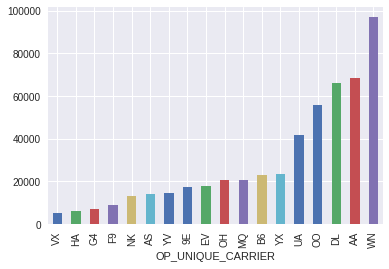

In [13]:
df.groupby('OP_UNIQUE_CARRIER').count()['YEAR'].sort_values(ascending=True).plot(kind='bar')

In [0]:
from sklearn.preprocessing import LabelEncoder


lb_make = LabelEncoder()
df['Airline_Carrier_Code'] = lb_make.fit_transform(df['OP_UNIQUE_CARRIER'])
df['Origin_Code'] = lb_make.fit_transform(df['ORIGIN'])
df['Destination_Code'] =  lb_make.fit_transform(df['DEST'])

## Something to note is that arrival airports and destination airports that are the same place will have different codes

In [0]:

## Double check our work
df[["OP_UNIQUE_CARRIER", 'Airline_Carrier_Code']].drop_duplicates(), df[["ORIGIN", 'Origin_Code']].drop_duplicates(),df[["DEST", 'Destination_Code']].drop_duplicates()


In [0]:
## Let's drop columns we don't need for the time being
df_r=df.drop(['YEAR', 'MONTH','OP_UNIQUE_CARRIER','ORIGIN','DEST'],axis=1)


##The Science

### Data Correlation

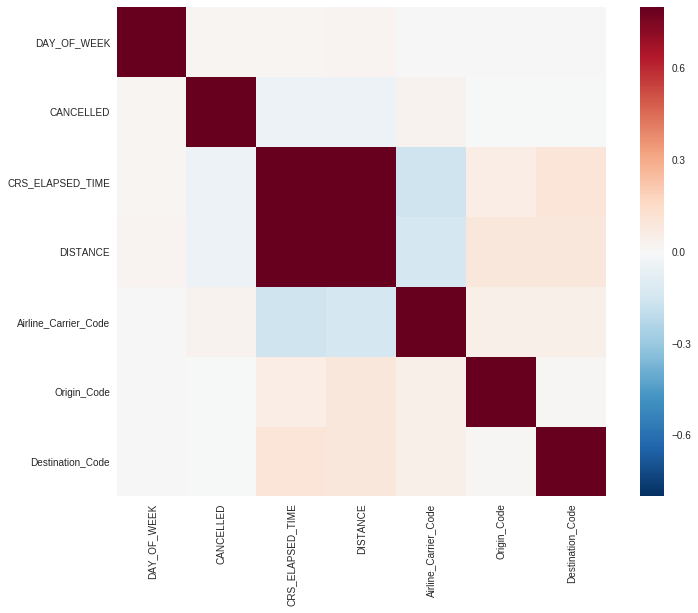

In [127]:
## Get a quick sense of correlation
f, ax = plt.subplots(figsize=(12, 9))
corrmat = df_r.corr()
sns.heatmap(corrmat, vmax=.8, square=True)


It looks like Distance and time elapsed are highly correlated, nothing shocking here let's not combine these features just yet though.

### Feature Engineering

In [0]:
### Let's use a different approach then I was thinking

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#Create dummy variables / features for all the categorical type data
features = pd.get_dummies(df.loc[:,['ORIGIN','DEST','OP_UNIQUE_CARRIER']])



In [0]:
features['DAY_OF_WEEK'] = df['DAY_OF_WEEK']
features['CRS_ELAPSED_TIME'] =df['CRS_ELAPSED_TIME']
features['DISTANCE'] = df['DISTANCE']

outcome = df['CANCELLED']

In [0]:
#Select the best features with highest K score by using f regression
selector = SelectKBest(f_regression, k=15)
selector.fit(features,outcome)

idxs_selected = selector.get_support(indices=True)
features[features.columns[idxs_selected]].head(1)

,ORIGIN_ASE,ORIGIN_ATL,ORIGIN_MDW,ORIGIN_ORD,ORIGIN_SUN,ORIGIN_UIN,DEST_ATL,DEST_MDW,DEST_ORD,OP_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_MQ,OP_UNIQUE_CARRIER_OO,OP_UNIQUE_CARRIER_UA,CRS_ELAPSED_TIME,DISTANCE
0,0,0,0,0,0,0,0,0,0,0,0,0,0,273.0,2174.0


In [0]:
features_best = features[features.columns[idxs_selected]]

features_best

In [115]:
#Stats Models
import statsmodels.formula.api as smf
x = features_best

results = smf.OLS(outcome,x).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              CANCELLED   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1375.
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        20:56:37   Log-Likelihood:             3.2848e+05
No. Observations:              520724   AIC:                        -6.569e+05
Df Residuals:                  520709   BIC:                        -6.568e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
ORIGIN_ASE               0.1009 

In [0]:
# All the features have a pvalue less than .05 so we don't need to weed any more of them out
#Split the data
from sklearn.model_selection import train_test_split

features_train, features_test, outcome_train, outcome_test = train_test_split(features_best, outcome, test_size=0.30)

In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

# Instantiate and fit our model.
regr = linear_model.LinearRegression()

parameters = {'normalize':[True,False]}

#Note for regression problems have to do different scoreing methods:
grid = GridSearchCV(regr, parameters, scoring='r2', cv=5, verbose=0)


#Fit the Data
grid.fit(features_train, outcome_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'normalize': [True, False]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='r2', verbose=0)

In [113]:
grid.best_score_

0.022717997148446672

In [116]:
## Test this flower of a model on the test set 

#Test Data with validation holdout
#Inspect the results.
print('\nCoefficients: \n', grid.best_estimator_.coef_)
print('\nIntercept: \n', grid.best_estimator_.intercept_)
print('\nR-squared:')
print(grid.score(features_test, outcome_test))


Coefficients: 
 [ 9.34752330e-02 -5.60333115e-03  9.25198130e-02  2.72368851e-02
  1.49137417e-01  1.75149091e-01 -6.01119024e-03  7.90960177e-02
  2.82002662e-02 -9.96602357e-03  3.31950855e-02  4.23637641e-03
 -1.34148779e-02  8.31916213e-05 -1.73061185e-05]

Intercept: 
 0.01563989699917809

R-squared:
0.02128220973727868


While this model is not very accurate it is however precise in it's inaccuracy, as it didn't change much when comparing to our test set.

### Linear Regression

In [0]:
# We want to create two regression models first the linear model
import math

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
linear_formula = 'CANCELLED ~ DAY_OF_WEEK+CRS_ELAPSED_TIME+DISTANCE+Airline_Carrier_Code+Origin_Code+Destination_Code'

lm = smf.ols(formula=linear_formula, data=df_r).fit()


In [90]:
print('Parameters:\n',lm.params,'\n\nP-Values:\n',lm.pvalues,'\n\nR-Squared:',lm.rsquared)



Parameters:
 Intercept               1.105431e-02
DAY_OF_WEEK             1.013753e-03
CRS_ELAPSED_TIME        1.024117e-04
DISTANCE               -2.248886e-05
Airline_Carrier_Code    5.849447e-04
Origin_Code             1.973028e-06
Destination_Code       -4.751313e-07
dtype: float64 

P-Values:
 Intercept               9.950229e-34
DAY_OF_WEEK             6.706119e-29
CRS_ELAPSED_TIME        3.766654e-18
DISTANCE                1.024514e-52
Airline_Carrier_Code    2.622423e-71
Origin_Code             3.239648e-01
Destination_Code        8.113957e-01
dtype: float64 

R-Squared: 0.003259479093594808


Evaluting our Pvalues it seems like Origin Code and Destination code may not provide much additional information.

Our linear model is having a tough time explaining much of anything on our first pass.

In [129]:
linear_formula = 'CANCELLED ~ DAY_OF_WEEK+CRS_ELAPSED_TIME+DISTANCE+Airline_Carrier_Code'

lm = smf.ols(formula=linear_formula, data=df_r).fit()
print('Parameters:\n',lm.params,'\n\nP-Values:\n',lm.pvalues,'\n\nR-Squared:',lm.rsquared)



Parameters:
 Intercept               0.011349
DAY_OF_WEEK             0.001014
CRS_ELAPSED_TIME        0.000101
DISTANCE               -0.000022
Airline_Carrier_Code    0.000586
dtype: float64 

P-Values:
 Intercept               8.242975e-45
DAY_OF_WEEK             6.650567e-29
CRS_ELAPSED_TIME        5.704410e-18
DISTANCE                6.970036e-53
Airline_Carrier_Code    5.106482e-72
dtype: float64 

R-Squared: 0.0032575152860431222


A linear model just may not work here let's take a first pass with KNN for now this model is so bad at describing the variance of our data we'll hold off testing it's predictive "prowess"


### KNN Regression

#### Non-Weighted

In [121]:
from sklearn import neighbors



knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X=df_r.loc[:,df_r.columns !='CANCELLED']
Y=df_r['CANCELLED']
knn.fit(X, Y)

print('\nR-squared:')
print(knn.score(X, Y))



R-squared:
0.1257693187131832


While this regression in the grand scheme of things isn't a great model it is better let's tweak this regression and see if we can make it perform a little  better.

First let's change to One-Hot encoding

In [0]:
from sklearn import neighbors



knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X=df_r.loc[:,df_r.columns !='CANCELLED']
Y=df_r['CANCELLED']
knn.fit(X, Y)

print('\nR-squared:')
print(knn.score(X, Y))

#### One Hot Encoding

Running into memory errors as there are so many columns from our one hot encoding, let's try eliminting some and see what happens

In [45]:
df_knn=df[df['CRS_ELAPSED_TIME'].notnull()].drop(['DEST'],axis=1)

df_knn=pd.get_dummies(df_knn)

df_knn.head()

,YEAR,MONTH,DAY_OF_WEEK,CANCELLED,CRS_ELAPSED_TIME,DISTANCE,OP_UNIQUE_CARRIER_9E,OP_UNIQUE_CARRIER_AA,OP_UNIQUE_CARRIER_AS,OP_UNIQUE_CARRIER_B6,...,ORIGIN_TYR,ORIGIN_TYS,ORIGIN_UIN,ORIGIN_USA,ORIGIN_VLD,ORIGIN_VPS,ORIGIN_WRG,ORIGIN_XNA,ORIGIN_YAK,ORIGIN_YUM
0,2018,2,4,0.0,273.0,2174.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2018,2,4,0.0,140.0,862.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018,2,4,0.0,225.0,1747.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2018,2,4,0.0,261.0,2039.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2018,2,4,0.0,215.0,1546.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X=df_knn.loc[:,df_knn.columns !='CANCELLED']
Y=df_knn['CANCELLED']
knn.fit(X, Y)

print('\nR-squared:')
print(knn.score(X, Y))


R-squared:
0.12431941506986388


#### Optimized KNN Regression

In [0]:
from sklearn.model_selection import GridSearchCV

#X=df_r.loc[:,df_r.columns !='CANCELLED']
X=df_r.loc[:,'CRS_ELAPSED_TIME',	'DISTANCE']
Y=df_r['CANCELLED']

knn = neighbors.KNeighborsRegressor()

parameters = {
    'n_neighbors':np.arange(11, 102, 5),
    'weights':['uniform','distance']
}

grid = GridSearchCV(knn, parameters, scoring='r2', cv=5, verbose=0)
#Fit the Data
grid.fit(X, Y)

In [0]:
grid.best_params_

In [44]:
df_r.loc[:,'CRS_ELAPSED_TIME',	'DISTANCE']

NameError: ignored

In [42]:
np.arange(11, 102, 5)

array([  121,   256,   441,   676,   961,  1296,  1681,  2116,  2601,
        3136,  3721,  4356,  5041,  5776,  6561,  7396,  8281,  9216,
       10201])

In [0]:
df_ac=df.groupby(['OP_UNIQUE_CARRIER','CANCELLED']).count()['YEAR'].reset_index()

df_ac[df_ac['CANCELLED']==1].YEAR.sum()/(df_ac[df_ac['CANCELLED']==1].YEAR.sum()+df_ac[df_ac['CANCELLED']==0].YEAR.sum())*100

1.7237306786037319

We have a possible problem with class imbalance here.

The percentage of canceled flight for the entire month is ~ 1.7%

Instead of a generalized model, lets look for the highest rate of canceled occurance in a specific categorization and creat a model off of that subset.

In [0]:
df_dc = df.groupby(['DAY_OF_WEEK','CANCELLED']).count()['YEAR'].reset_index()

df_dc[df_dc['CANCELLED']==1]['YEAR'],df_dc[df_dc['CANCELLED']==0]['YEAR']

(1     1035
 3     1148
 5     1596
 7     1086
 9     1807
 11     619
 13    1685
 Name: YEAR, dtype: int64, 0     77633
 2     74458
 4     74487
 6     77618
 8     77435
 10    60746
 12    69378
 Name: YEAR, dtype: int64)

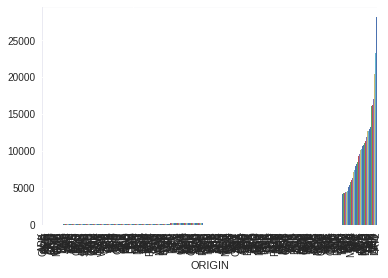

In [0]:
df.groupby('ORIGIN').count()['YEAR'].sort_values(ascending=True).plot(kind='bar')

Looks like there are a lot of flights from airports with very low representation with in the data, lets get rid of these.

In [0]:
df.groupby('ORIGIN').count()['YEAR'].sort_values(ascending=True).describe()

count      336.000000
mean      1549.794643
std       3583.880881
min          8.000000
25%         77.750000
50%        252.500000
75%        968.750000
max      28125.000000
Name: YEAR, dtype: float64

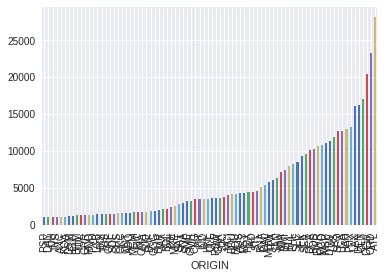

In [0]:
test=df.groupby('ORIGIN').count().sort_values(by='YEAR',ascending=True)

test[test['YEAR']>1000]['YEAR'].plot(kind='bar')



82


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


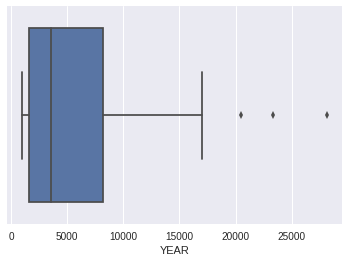

In [0]:
sns.boxplot(test[test['YEAR']>1000]['YEAR'])



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


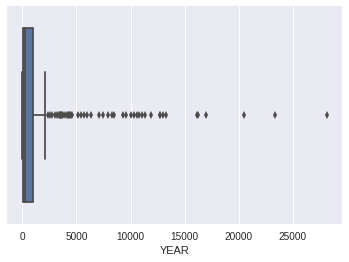

In [0]:
sns.boxplot(df.groupby('ORIGIN').count().sort_values(by = 'YEAR',ascending=True)['YEAR'])

In [0]:
df.groupby(['ORIGIN','CANCELLED']).count()['YEAR']

In [0]:
df.groupby(['OP_UNIQUE_CARRIER','CANCELLED']).count()['YEAR'].reset_index()

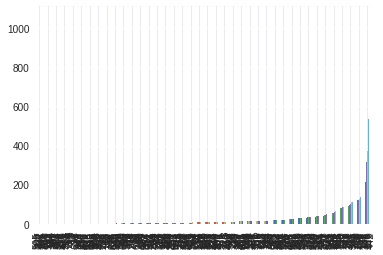

In [0]:
df_oc=pd.DataFrame(df.groupby(['ORIGIN','CANCELLED']).count()['YEAR']).reset_index()

df_oc[df_oc['CANCELLED']==1].sort_values(by = 'YEAR', ascending = True)['YEAR'].plot(kind='bar')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


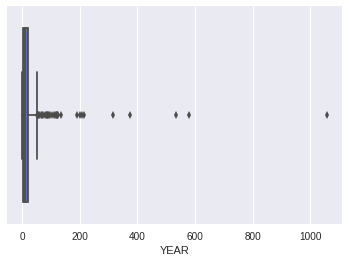

In [0]:
sns.boxplot(df_oc[df_oc['CANCELLED']==1].sort_values(by = 'YEAR', ascending = True)['YEAR'])

Intturpreting the graphs above we have a class imbalance issue.

As certain Airports are drastically more represented than other airports. This class imbalance is going to be an issue for any type of model